In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
%precision %.4f

from collections import namedtuple
from dateutil.relativedelta import relativedelta
from datetime import date, datetime, timedelta
import pandas_datareader.data as pdr
from pandas_datareader.fred import FredReader
import seaborn as sns

'%.4f'

In [2]:
# FRED CMT data
tickers = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
tenors = [1, 2, 3, 5, 7, 10, 20, 30] # => charts scale
#tenors = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
end_date = datetime.today() # custom datetime(YYYY,MM,DD)
start_date = end_date - relativedelta(years=1)
level = False # True for level pca and False for change pca
scaling = False 
freq = 'D' # D/W/M

df = pd.DataFrame()
for ticker in tickers:
    reader = FredReader(ticker, start_date, end_date)
    df0 = reader.read()
    df = df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)
df.dropna(axis = 0, inplace = True)
df.tail(5)

,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,
2022-02-28,1.01,1.44,1.62,1.71,1.81,1.83,2.25,2.17
2022-03-01,0.91,1.31,1.47,1.56,1.67,1.72,2.19,2.11
2022-03-02,1.06,1.50,1.67,1.74,1.83,1.86,2.32,2.24
2022-03-03,1.08,1.53,1.69,1.74,1.82,1.86,2.32,2.24
2022-03-04,1.05,1.50,1.62,1.65,1.70,1.74,2.23,2.16


In [8]:
# PCA on 

# data cleaning
df_daily = df.resample(freq).last()
df_daily.dropna(axis = 0, inplace = True)
df_daily_centered = df_daily.sub(df_daily.mean())

from sklearn.decomposition import PCA
pca_level = PCA().fit(df_daily)


[0.7905386  0.94424406 0.97325424 0.98367809 0.99059073 0.99468333
 0.99775556 1.        ]


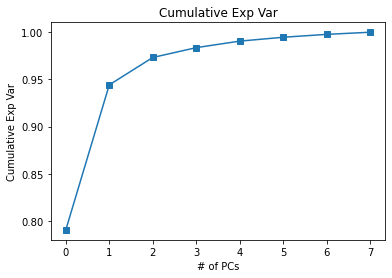

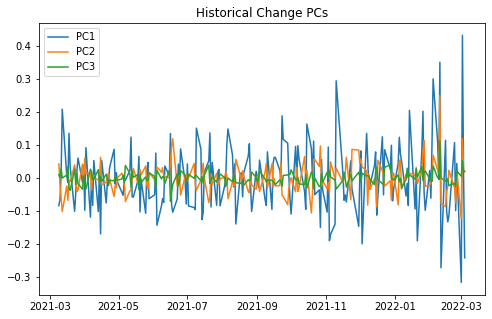

           PC_1      PC_2      PC_3
DGS1   0.167129  0.359786  0.672073
DGS2   0.263416  0.502627  0.218075
DGS3   0.330661  0.429834 -0.109381
DGS5   0.401299  0.191763 -0.433904
DGS7   0.425682 -0.030571 -0.327884
DGS10  0.420881 -0.214051 -0.089526
DGS20  0.375968 -0.390646  0.223040
DGS30  0.364150 -0.443885  0.367771


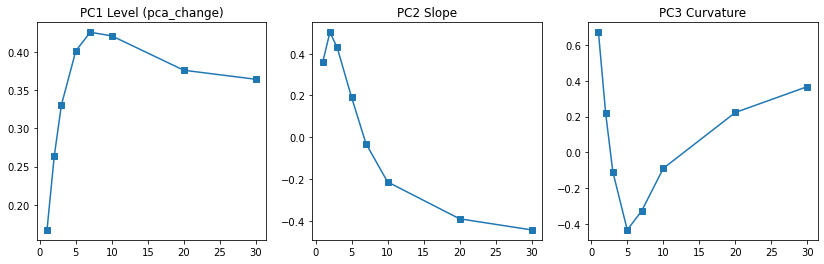

In [10]:
# PCA on Change

# data cleaning
df_daily = df.resample(freq).last()
df_daily_diff = df_daily.diff()
df_daily_diff.dropna(inplace=True)
df_daily_diff_centered = df_daily_diff.sub(df_daily_diff.mean())

# run PCA
from sklearn.decomposition import PCA
pca_change = PCA().fit(df_daily_diff)

# Explained variance plot
plt.plot(pca_change.explained_variance_ratio_.cumsum(),"-s");
plt.title("Cumulative Exp Var")
plt.xlabel('# of PCs');
plt.ylabel('Cumulative Exp Var');

# top 3 PCs explain 95%+ of the variance
print(pca_change.explained_variance_ratio_.cumsum())

df_pca_change = pca_change.transform(df_daily_diff) # score matrix
df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PC_{x+1}' for x in range(df_pca_change.shape[1])])
df_pca_change.index = df_daily_diff.index

# plot historical PCs
plt.figure(figsize=(8,5))
plt.title("Historical Change PCs") 
plt.plot(df_pca_change['PC_1'], label='PC1')
plt.plot(df_pca_change['PC_2'], label='PC2')
plt.plot(df_pca_change['PC_3'], label='PC3')
plt.legend()
plt.show();

# plot the loadings vs tenor
plt.figure(figsize=(14,4)) 
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors, pca_change.components_[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors, pca_change.components_[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors, pca_change.components_[2, :], "-s");
# e.g. if PC1 moves by 1 unit, yields for all tenors increase, with 7y the most (0.42bps)

W_change = pd.DataFrame(pca_change.components_.T)
W_change.columns = [f'PC_{i+1}' for i in range(W_change.shape[1])]
W_change.index = tickers
print(W_change.iloc[:,0:3]); # loadings/weights matrix - what was plotted above

In [129]:
# Analytics: 

# Map dv01 risk to PC risk via W_T * nom_risk = pc_risk

tickers = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
tenors = [1, 2, 3, 5, 7, 10, 20, 30]
nom_risk = np.array([0,0.48,0,-1,0,0.65,0,0])
pc_risk = np.matmul(pca_change.components_[0:3,:],nom_risk)
print(pc_risk)
print(pd.DataFrame(nom_risk,tenors, columns =['DV01']))
print(pd.DataFrame(pc_risk, ['PC1','PC2','PC3'], columns =['PC01']))

[-0.00156162 -0.08972404  0.48262164]
    DV01
1   0.00
2   0.48
3   0.00
5  -1.00
7   0.00
10  0.65
20  0.00
30  0.00
         PC01
PC1 -0.001562
PC2 -0.089724
PC3  0.482622


In [ ]:
#print(pca_change.explained_variance_) # eigenvalues
#print(pca_change.explained_variance_ratio_) # eigenvalue / sum(eigenvalue)
#print(pca_change.explained_variance_ratio_.cumsum())
#d=pd.DataFrame(pca_change.explained_variance_ratio_.cumsum(),pca_change.explained_variance_ratio_,columns = ['Cumulative Sum'])
#print(d)
risk_nom = {
    '1Y':0,
    '2Y':10,
    '3Y':0,
    '5Y':-20,
    '7Y':0,
    '10Y':10,
    '20Y':0,  
    '30Y':0}
print(risk_nom['2Y'])

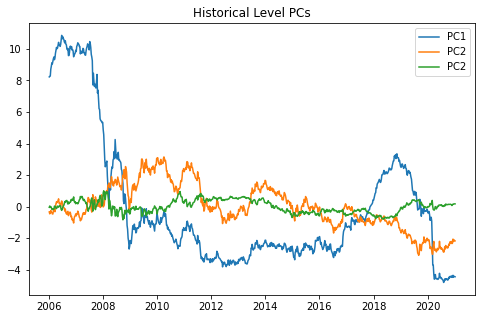

In [80]:
df_pca_level = pca_level.transform(df_daily) # transform -> score matrix; uses mean from .fit() to center but doesn't scale by s.d.
df_pca_level = pd.DataFrame(df_pca_level, columns=[f'PCA_{x+1}' for x in range(df_pca_level.shape[1])])  # output into dataframe, rename with f string
df_pca_level.index = df_daily.index

plt.figure(figsize=(8,5))
plt.title("Historical Level PCs")
plt.plot(df_pca_level['PCA_1'], label='PC1')
plt.plot(df_pca_level['PCA_2'], label='PC2')
plt.plot(df_pca_level['PCA_3'], label='PC2')  
plt.legend()
plt.show();

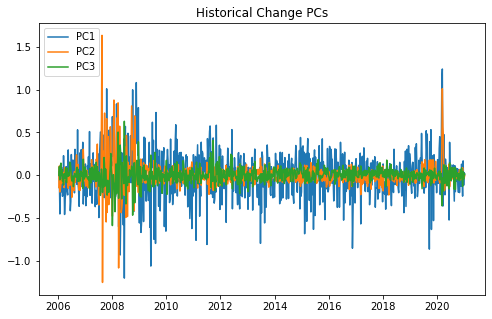

In [81]:
df_pca_change = pca_change.transform(df_daily_diff)
df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PCA_{x+1}' for x in range(df_pca_change.shape[1])])
df_pca_change.index = df_daily_diff.index

plt.figure(figsize=(8,5))
plt.title("Historical Change PCs")
plt.plot(df_pca_change['PCA_1'], label='PC1')
plt.plot(df_pca_change['PCA_2'], label='PC2')
plt.plot(df_pca_change['PCA_3'], label='PC3')
plt.legend()
plt.show();

In [ ]:
# print(pca_change.singular_values_)
# print(pca_change.get_covariance())
print(pd.DataFrame(pca_change.components_.T)) # note .components_ is s.t. ith row is PCi's loading vector 

In [ ]:
# checkpoint
print(df_pca_change.iloc[:3,:3]) # show PC score / value of each PC; score = centered(df) * .components_.T
print(np.matmul(df_daily_diff_centered, pca_change.components_.T).iloc[:3, :3]) # centered(df) * .components_.T, should be same as above, ignore col names
print(np.matmul(pca_change.components_, pca_change.components_.T)[1,1]) # should both be 1 / entry from I
print(np.matmul(pca_change.components_.T, pca_change.components_)[2,2])

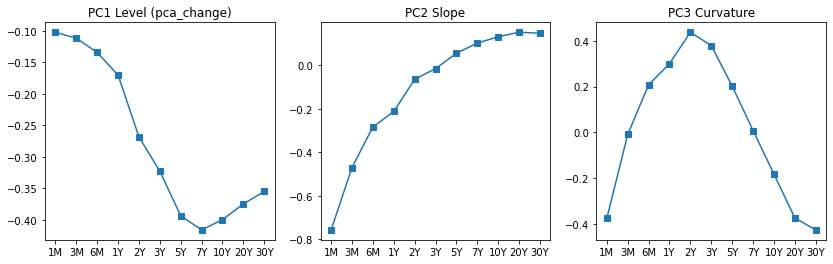

In [140]:
tenors = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
plt.figure(figsize=(14,4))
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors, pca_change.components_[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors, pca_change.components_[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors, pca_change.components_[2, :], "-s");
# e.g. if PC1 moves by 1 unit, yields for all tenors fall, 7y the most (-0.4bps)


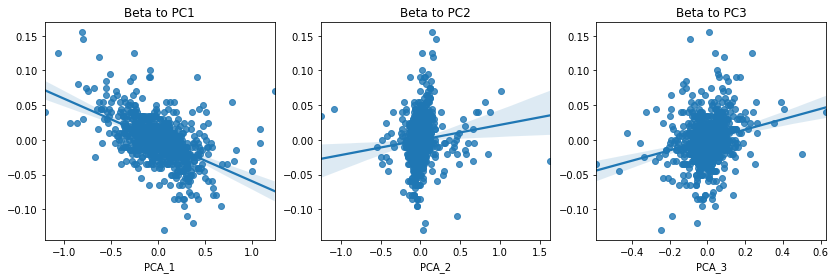

In [161]:
fly5050 = df_daily_diff['DGS5'] - (df_daily_diff['DGS2'] + df_daily_diff['DGS10'])*0.5
plt.figure(figsize=(14,4))
plt.subplot(131, title = "Beta to PC1")
sns.regplot(x=df_pca_change['PCA_1'], y=fly5050);
plt.subplot(132, title = "Beta to PC2")
sns.regplot(x=df_pca_change['PCA_2'], y=fly5050);
plt.subplot(133, title = "Beta to PC3")
sns.regplot(x=df_pca_change['PCA_3'], y=fly5050);

# 2s5s10s negatively correlated with PC1
# 2s5s10s higher, PC1 moves lower, duration cheaper; confirming tendency for 2s5s10s positive correlation with duration (cheaper => cheaper)

In [104]:
W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PC_{i+1}' for i in range(W.shape[1])]
W.index = tickers

# w ij = loading of ith feature/yield of PC j

w21 = W.loc['DGS2', 'PC_1']
w22 = W.loc['DGS2', 'PC_2']
w23 = W.loc['DGS2', 'PC_3']

w51 = W.loc['DGS5', 'PC_1']
w52 = W.loc['DGS5', 'PC_2']
w53 = W.loc['DGS5', 'PC_3']

w101 = W.loc['DGS10', 'PC_1']
w102 = W.loc['DGS10', 'PC_2']
w103 = W.loc['DGS10', 'PC_3']

w551 = w51 - (w21+w101) * 0.5 # PC1 exposure of 5050 fly
w552 = w52 - (w22+w102) * 0.5 # PC1 exposure of 5050 fly
print(w551, w552)
print(W.iloc[:5,0:3]) # loading matrix

0.05899279629925008 0.04753107215958918
          PC_1      PC_2      PC_3
DGS1  0.168187  0.359206  0.678063
DGS2  0.267204  0.500781  0.211898
DGS3  0.331504  0.429047 -0.109742
DGS5  0.401846  0.190664 -0.437021
DGS7  0.423381 -0.030804 -0.324535


In [189]:
# solve sim eq Ab = x to get PC1+2 neutral weights
A = np.array([[w21, w101],[w22, w102]])
b = np.array([w51, w52])
x,y = np.matmul(np.linalg.inv(A), b)
print(x,y)

0.4859957458180914 0.6583663710956318


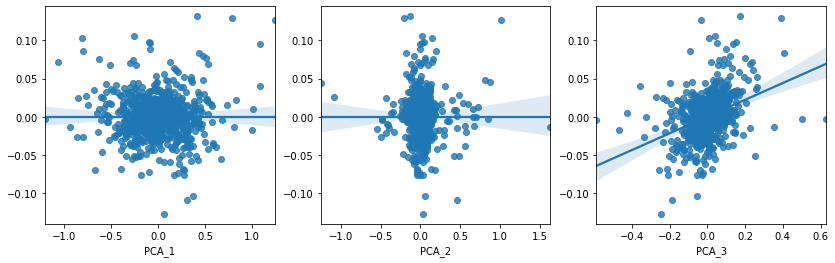

In [196]:
flypca = df_daily_diff['DGS5']*1 - (x*df_daily_diff['DGS2']+y*df_daily_diff['DGS10'])
plt.figure(figsize=(14,4))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=flypca);
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=flypca);
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=flypca);

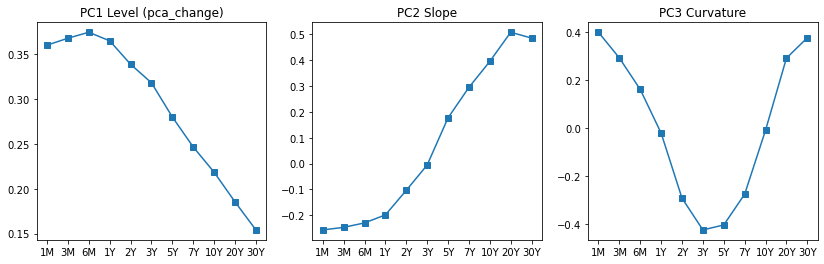

In [200]:
tenors = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
plt.figure(figsize=(14,4))
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors, pca_level.components_[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors, pca_level.components_[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors, pca_level.components_[2, :], "-s");
# e.g. if PC1 moves by 1 unit, yields for all tenors fall, 7y the most (-0.4bps)

In [199]:
W = pd.DataFrame(pca_level.components_.T)
W.columns = [f'PCA_{i+1}' for i in range(W.shape[1])]
W.index = tickers
print(W.iloc[:5,0:3]) # loading matrix

# interpretation of pca_level loadings
# when PC1 realises, the curve is higher relative to avg with front end higher than long end

           PCA_1     PCA_2     PCA_3
DGS1MO  0.360233 -0.256559  0.399132
DGS3MO  0.367960 -0.246667  0.292259
DGS6MO  0.374633 -0.229425  0.161016
DGS1    0.365075 -0.198418 -0.020539
DGS2    0.338908 -0.103316 -0.291483


In [208]:
# mapping: nominal risk -> PC risk

nom_risk = np.array([0,0,0,0,0.48,0,-1,0,0.65,0,0])

pc_risk = np.matmul(pca_change.components_[0:3,:],nom_risk)

print(pc_risk)

[ 0.00495114 -0.00071615 -0.11061197]


In [ ]:
W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PCA_{i+1}' for i in range(W.shape[1])]
W.index = tickers

In [205]:
pca_change.components_[0:3,:]

array([[-0.10250026, -0.11200385, -0.13449477, -0.17040677, -0.26827879,
        -0.32284454, -0.39341869, -0.41581462, -0.39952882, -0.37463736,
        -0.35491257],
       [-0.75712007, -0.47010396, -0.28349481, -0.21223415, -0.06440793,
        -0.01479149,  0.05544223,  0.10253679,  0.13175675,  0.15237337,
         0.1477381 ],
       [-0.37420159, -0.00867281,  0.20771456,  0.29967192,  0.43679404,
         0.37878349,  0.20263173,  0.00858399, -0.18098674, -0.37219168,
        -0.4245789 ]])

In [ ]:
# fly weight calculator
# residual/explained
# map nominal risk to pc risk
